In [40]:
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve



In [41]:
# Load the dataset
data = pd.read_csv("diabetes.csv")

# Basic EDA
print(data.head())
print(data.info())
print(data.describe())
print("Missing values:\n", data.isnull().sum())



   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

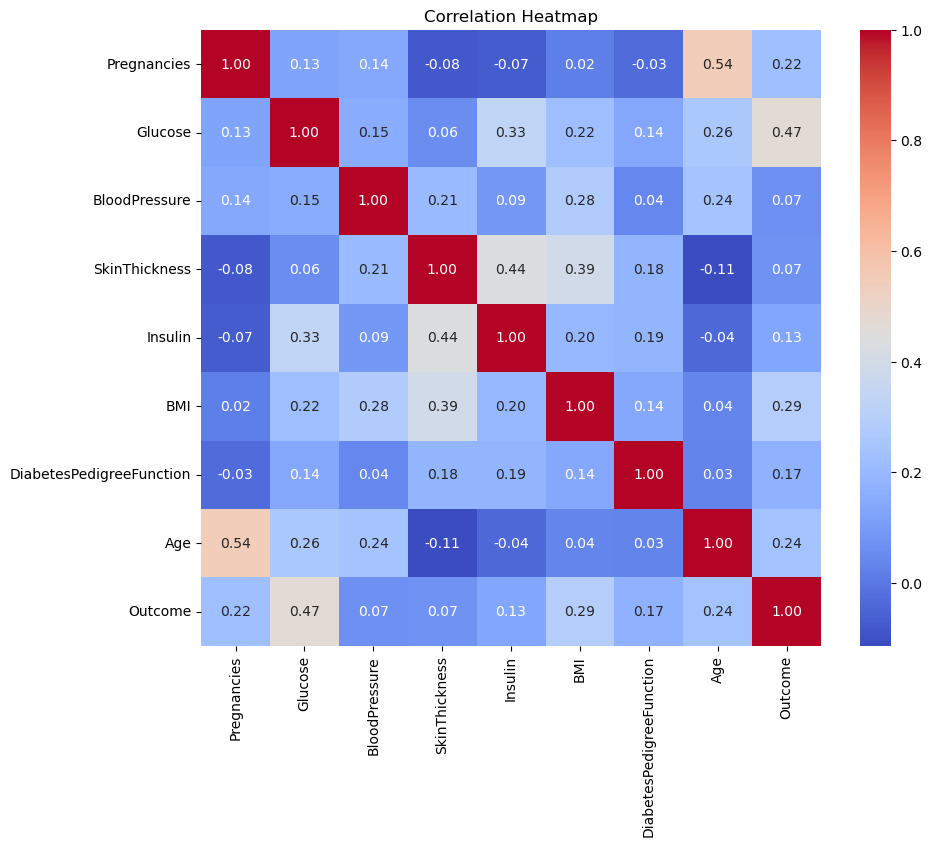

In [42]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()



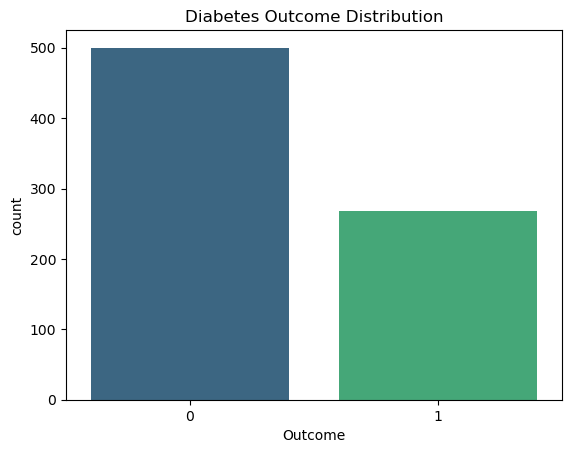

In [43]:
# Outcome distribution
sns.countplot(x='Outcome', data=data, palette='viridis')
plt.title("Diabetes Outcome Distribution")
plt.show()

# Feature-target split
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate multiple models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

results = {}




Training Random Forest...
Accuracy: 0.7597
ROC AUC: 0.8147
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154



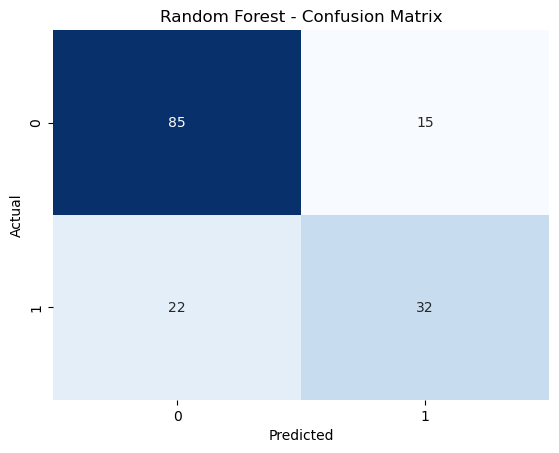


Training Gradient Boosting...
Accuracy: 0.7532
ROC AUC: 0.8398
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       100
           1       0.67      0.59      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



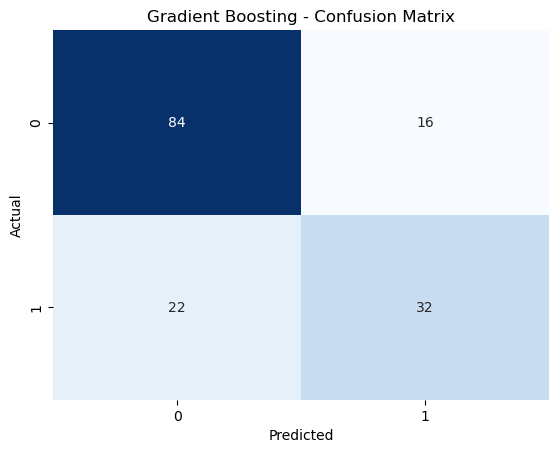


Training Support Vector Machine...
Accuracy: 0.7532
ROC AUC: 0.7924
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



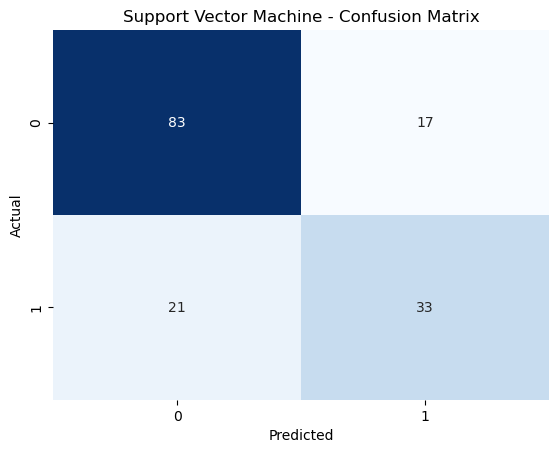

In [44]:
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    print(f"Accuracy: {accuracy:.4f}")
    if auc:
        print(f"ROC AUC: {auc:.4f}")
    
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    results[model_name] = {"accuracy": accuracy, "roc_auc": auc}





Performing Grid Search for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Best Model Accuracy: 0.7468
Best Model ROC AUC: 0.8135
Model saved as model.pkl


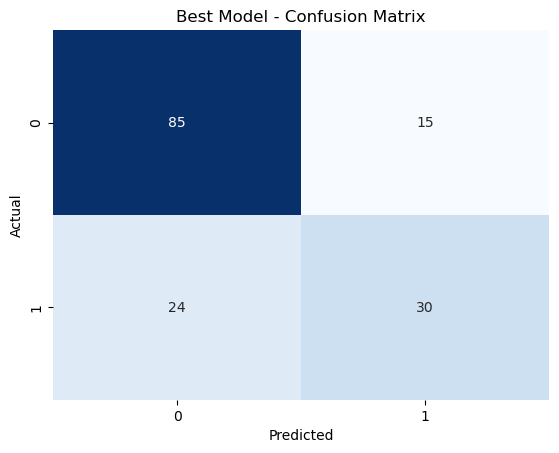

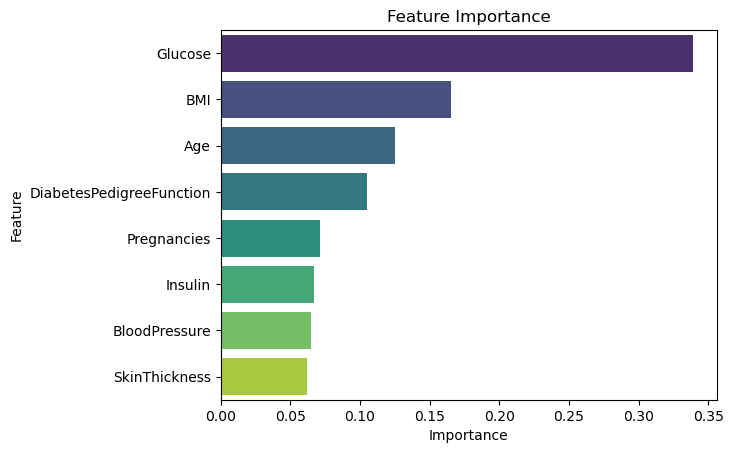

In [45]:
# Hyperparameter tuning for Random Forest
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

print("\nPerforming Grid Search for Random Forest...")
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_prob_best)
print(f"Best Model Accuracy: {accuracy_best:.4f}")
print(f"Best Model ROC AUC: {auc_best:.4f}")

# Save the best model
joblib.dump(best_model, 'model.pkl')
print("Model saved as model.pkl")

# Confusion matrix for the best model
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Best Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
if hasattr(best_model, "feature_importances_"):
    feature_importances = pd.DataFrame({
        "Feature": X.columns,
        "Importance": best_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    
    sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
    plt.title("Feature Importance")
    plt.show()




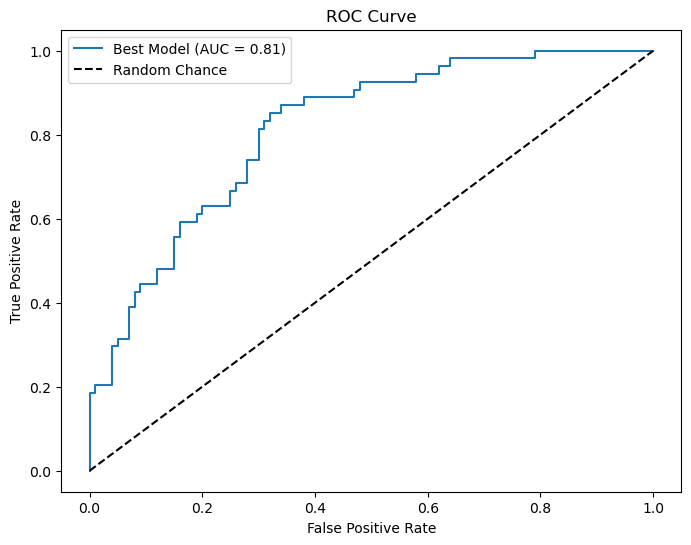

In [46]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Best Model (AUC = {auc_best:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()